# Определение перспективного тарифа для телеком-компании
Клиентам компании "Мегалайн" предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Даны данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание данных

Таблица <b>users</b> (информация о пользователях):
<ul>
<li>user_id — уникальный идентификатор пользователя</li>
<li>first_name — имя пользователя</li>
<li>last_name — фамилия пользователя</li>
<li>age — возраст пользователя (годы)</li>
<li>reg_date — дата подключения тарифа (день, месяц, год)</li>
<li>churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)</li>
<li>city — город проживания пользователя</li>
<li>tarif — название тарифного плана</li>
</ul>
Таблица <b>calls</b> (информация о звонках):
<ul>
<li>id — уникальный номер звонка</li>
<li>call_date — дата звонка</li>
<li>duration — длительность звонка в минутах</li>
<li>user_id — идентификатор пользователя, сделавшего звонок</li>
</ul>
Таблица <b>messages</b> (информация о сообщениях):
<ul>
<li>id — уникальный номер сообщения</li>
<li>message_date — дата сообщения</li>
<li>user_id — идентификатор пользователя, отправившего сообщение</li>
</ul>
Таблица <b>internet</b> (информация об интернет-сессиях):
<ul>
<li>id — уникальный номер сессии</li>
<li>mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)</li>
<li>session_date — дата интернет-сессии</li>
<li>user_id — идентификатор пользователя</li>
</ul>
Таблица <b>tariffs</b> (информация о тарифах):
<ul>
<li>tariff_name — название тарифа</li>
<li>rub_monthly_fee — ежемесячная абонентская плата в рублях</li>
<li>minutes_included — количество минут разговора в месяц, включённых в абонентскую плату</li>
<li>messages_included — количество сообщений в месяц, включённых в абонентскую плату</li>
<li>mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)</li>
<li>rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)</li>
<li>rub_per_message — стоимость отправки сообщения сверх тарифного пакета</li>
<li>rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)</li>
</ul>

In [4]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

# Изучение данных из файла

In [5]:
calls = pd.read_csv('calls.csv')
print(calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


In [6]:
display(calls.head(10))

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<b>Вывод:</b> в данном файле нет нулевых значений. Значений столбцов записаны в одном стиле. Здесь можно заметить, что есть нулевые значения в столбце duration. Хотя даже 1 секунда разговора будет защитана за минуту. Вероятно это вызовы, на которые не поступило ответа. Здесь следует заменить тип данных в столбце с датой звонка.

In [7]:
internet = pd.read_csv('internet.csv')
del internet['Unnamed: 0']
print(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None


In [8]:
display(internet.head(10))

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


<b>Вывод:</b> в данном датафрейме также нет нулевых значений. Значений столбцов записаны в одном стиле. Но стоит заменить тип данных в столбце session_date.

In [9]:
messages = pd.read_csv('messages.csv')
print(messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


In [10]:
display(messages.head(10))

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<b>Вывод:</b> здесь можно заметить, что дата записана в неверном формате.

In [11]:
tariffs = pd.read_csv('tariffs.csv')
print(tariffs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


In [12]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
users = pd.read_csv('users.csv')
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [14]:
display(users.head(10))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<b>Вывод:</b> в данном датафрейме уже присутствуют нулевые значения,но здесь они оправданы, так как данные пользователи продолжают пользоваться тарифом, а также не везде правильный тип данных в столбце.

# Подготовка данных

## Приведение данных к нужным типам

Рассмотрим таблицу calls. Здесь следует изменить тип данных в столбце call_date на дату.

In [15]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
display(calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


None

Рассмотрим таблицу internet. Здесь также следует заменить тип значений в столбце session_date на дату

In [16]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
display(internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


None

Рассмотрим таблицу messages. Здесь также заменяем дату.

In [17]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
display(messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


None

Рассмотрим таблицу users. Заменим тип данных в столбце с датой.

In [18]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     object        
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB
None


## Расчет данных для каждого пользователя

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [19]:
calls_count = calls.pivot_table(index = ['user_id', calls['call_date'].to_numpy().astype('datetime64[M]')], values = 'id', aggfunc = 'count').reset_index()
calls_count.columns = ['user_id','month', 'count_of_calls']

calls['duration'] = np.ceil(calls['duration'])
calls_duration_sum = calls.pivot_table(index = ['user_id',calls['call_date'].to_numpy().astype('datetime64[M]')], values = 'duration', aggfunc = 'sum').reset_index()
calls_duration_sum.columns = ['user_id','month', 'minutes']
calls_duration_sum['minutes'] = calls_duration_sum['minutes'].astype('int')

display(calls_count.head(10))
display(calls_duration_sum.head(10))

,user_id,month,count_of_calls
0,1000,2018-05-01,22
1,1000,2018-06-01,43
2,1000,2018-07-01,47
3,1000,2018-08-01,52
4,1000,2018-09-01,58
5,1000,2018-10-01,57
6,1000,2018-11-01,43
7,1000,2018-12-01,46
8,1001,2018-11-01,59
9,1001,2018-12-01,63


,user_id,month,minutes
0,1000,2018-05-01,159
1,1000,2018-06-01,172
2,1000,2018-07-01,340
3,1000,2018-08-01,408
4,1000,2018-09-01,466
5,1000,2018-10-01,350
6,1000,2018-11-01,338
7,1000,2018-12-01,333
8,1001,2018-11-01,430
9,1001,2018-12-01,414


### Количество отправленных сообщений по месяцам

In [20]:
messages_count = messages.pivot_table(index = ['user_id', messages['message_date'].to_numpy().astype('datetime64[M]')], values = 'id', aggfunc = 'count').reset_index()
messages_count.columns = ['user_id', 'month', 'count_of_messages']
display(messages_count.head(10))

,user_id,month,count_of_messages
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
5,1000,2018-10-01,73
6,1000,2018-11-01,58
7,1000,2018-12-01,70
8,1002,2018-06-01,4
9,1002,2018-07-01,11


### Объем израсходованного интернет-трафика по месяцам

In [21]:
internet_used_in_month = internet.pivot_table(index = ['user_id',internet['session_date'].to_numpy().astype('datetime64[M]')], values = 'mb_used', aggfunc = 'sum').reset_index()
internet_used_in_month.columns = ['user_id','month', 'mb_used']
internet_used_in_month['mb_used'] = (internet_used_in_month['mb_used']  / 1024).apply(np.ceil)
internet_used_in_month.columns = ['user_id','month', 'gb_used']
internet_used_in_month['gb_used'] = internet_used_in_month['gb_used'].astype('int') 

display(internet_used_in_month.head(10))

,user_id,month,gb_used
0,1000,2018-05-01,3
1,1000,2018-06-01,23
2,1000,2018-07-01,14
3,1000,2018-08-01,14
4,1000,2018-09-01,15
5,1000,2018-10-01,15
6,1000,2018-11-01,15
7,1000,2018-12-01,10
8,1001,2018-11-01,18
9,1001,2018-12-01,14


<b>Вывод:</b> можно заметить, что не по всем месяцам есть данные или не во все месяца были совершены звонки, отправлены сообщения или потрачены мегабайты интернета.

### Помесячная выручка с каждого пользователя

In [22]:
data = calls_count.merge(calls_duration_sum, on = ['user_id', 'month'], how = 'outer')
display(data.head(10))

,user_id,month,count_of_calls,minutes
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466
5,1000,2018-10-01,57,350
6,1000,2018-11-01,43,338
7,1000,2018-12-01,46,333
8,1001,2018-11-01,59,430
9,1001,2018-12-01,63,414


In [23]:
data = data.merge(messages_count, on = ['user_id', 'month'], how = 'outer')
display(data.head(10))

,user_id,month,count_of_calls,minutes,count_of_messages
0,1000,2018-05-01,22.0,159.0,22.0
1,1000,2018-06-01,43.0,172.0,60.0
2,1000,2018-07-01,47.0,340.0,75.0
3,1000,2018-08-01,52.0,408.0,81.0
4,1000,2018-09-01,58.0,466.0,57.0
5,1000,2018-10-01,57.0,350.0,73.0
6,1000,2018-11-01,43.0,338.0,58.0
7,1000,2018-12-01,46.0,333.0,70.0
8,1001,2018-11-01,59.0,430.0,NaN
9,1001,2018-12-01,63.0,414.0,NaN


In [24]:
data = data.merge(internet_used_in_month, on = ['user_id', 'month'], how = 'outer')
display(data.head(10))

,user_id,month,count_of_calls,minutes,count_of_messages,gb_used
0,1000,2018-05-01,22.0,159.0,22.0,3.0
1,1000,2018-06-01,43.0,172.0,60.0,23.0
2,1000,2018-07-01,47.0,340.0,75.0,14.0
3,1000,2018-08-01,52.0,408.0,81.0,14.0
4,1000,2018-09-01,58.0,466.0,57.0,15.0
5,1000,2018-10-01,57.0,350.0,73.0,15.0
6,1000,2018-11-01,43.0,338.0,58.0,15.0
7,1000,2018-12-01,46.0,333.0,70.0,10.0
8,1001,2018-11-01,59.0,430.0,NaN,18.0
9,1001,2018-12-01,63.0,414.0,NaN,14.0


In [25]:
data = data.merge(users, on = 'user_id', how = 'outer')
display(data.head(10))

,user_id,month,count_of_calls,minutes,count_of_messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,2018-05-01,22.0,159.0,22.0,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,2018-06-01,43.0,172.0,60.0,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,2018-07-01,47.0,340.0,75.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,2018-08-01,52.0,408.0,81.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,2018-09-01,58.0,466.0,57.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,2018-10-01,57.0,350.0,73.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,2018-11-01,43.0,338.0,58.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,2018-12-01,46.0,333.0,70.0,10.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,2018-11-01,59.0,430.0,NaN,18.0,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
9,1001,2018-12-01,63.0,414.0,NaN,14.0,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


In [26]:
data.user_id.nunique()

500

In [27]:
data.columns = ['user_id', 'month', 'count_of_calls', 'minutes', 'count_of_messages', 'gb_used', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff_name']
data = data.merge(tariffs, on = 'tariff_name', how = 'outer')
display(data.head())

,user_id,month,count_of_calls,minutes,count_of_messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,22.0,159.0,22.0,3.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,43.0,172.0,60.0,23.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,47.0,340.0,75.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,52.0,408.0,81.0,14.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,58.0,466.0,57.0,15.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [28]:
def profit(row):
    profit = 0
    if (row['minutes_included'] - row['minutes']) < 0:
        profit += abs(row['minutes_included'] - row['minutes']) * row['rub_per_minute']
    if (row['messages_included'] - row['count_of_messages']) < 0:
        profit += abs(row['messages_included'] - row['count_of_messages']) * row['rub_per_message']
    if ((row['mb_per_month_included'])/1024 - row['gb_used']) < 0:
        profit += abs((row['mb_per_month_included'])/1024 - row['gb_used']) * row['rub_per_gb']
    profit += row['rub_monthly_fee']
    return profit

data['profit'] = data.apply(profit, axis = 1)
display(data.head(10))

,user_id,month,count_of_calls,minutes,count_of_messages,gb_used,age,churn_date,city,first_name,...,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,2018-05-01,22.0,159.0,22.0,3.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,2018-06-01,43.0,172.0,60.0,23.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,2018-07-01,47.0,340.0,75.0,14.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,2018-08-01,52.0,408.0,81.0,14.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,2018-09-01,58.0,466.0,57.0,15.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
5,1000,2018-10-01,57.0,350.0,73.0,15.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
6,1000,2018-11-01,43.0,338.0,58.0,15.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
7,1000,2018-12-01,46.0,333.0,70.0,10.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
8,1003,2018-08-01,55.0,380.0,37.0,9.0,23,NaN,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,1950.0
9,1003,2018-09-01,134.0,961.0,91.0,13.0,23,NaN,Москва,Белла,...,2018-08-17,ultra,1000,30720,3000,1950,150,1,1,1950.0


In [29]:
data['profit'].describe()

count    3216.000000
mean     1528.902674
std       798.224060
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: profit, dtype: float64

<b>Вывод:</b> в данном пункте была построена сводная таблица по всем пользователям, их тарифу, количеству совершенных звонков, отправленных смс, использованного интернета. И в дальнейшем найдем доход по каждому пользователю.

# Анализ данных

## Сколько минут разговора требуется пользователям каждого тарифа в месяц?

                   mean           var         std
tariff_name                                      
smart        419.062978  35844.189551  189.325618
ultra        545.451104  94203.418396  306.925754


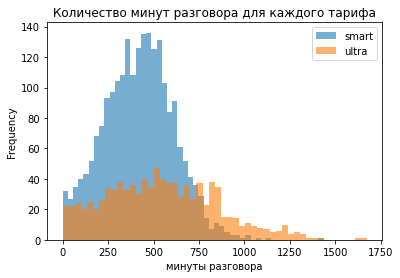

In [30]:
data.groupby('tariff_name')['minutes'].plot(kind = 'hist', bins = 50, title = 'Количество минут разговора для каждого тарифа', alpha = 0.6, legend = True)
plt.xlabel('минуты разговора')

stats_for_calls = data.pivot_table(index = 'tariff_name', values = 'minutes', aggfunc = ['mean', 'var', 'std'])
stats_for_calls.columns = ['mean', 'var', 'std']
print(stats_for_calls)

<b>Вывод:</b> в данных двух тарифах отличаются как среднее, так и дисперсия с отклонением. По графику также видны отличия. Распределение графика smart близко к нормальному с пиком около 500 звонков. График по тарифу ultra смещен влево.

## Сколько сообщений требуется пользователям каждого тарифа в месяц?

                  mean          var        std
tariff_name                                   
smart        38.716441   717.594201  26.787949
ultra        61.161006  2109.659183  45.931026


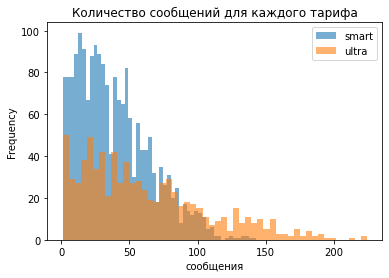

In [31]:
data.groupby('tariff_name')['count_of_messages'].plot(kind = 'hist', bins = 50, title = 'Количество сообщений для каждого тарифа', alpha = 0.6, legend = True)
plt.xlabel('сообщения')
stats_for_messages = data.pivot_table(index = 'tariff_name', values = 'count_of_messages', aggfunc = ['mean', 'var', 'std'])
stats_for_messages.columns = ['mean', 'var', 'std']
print(stats_for_messages)

<b>Вывод:</b> распределение и по одному и по второму графику распределение Пуассона. 

## Какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

                  mean        var       std
tariff_name                                
smart        16.336176  32.923756  5.737923
ultra        19.694359  94.146734  9.702924


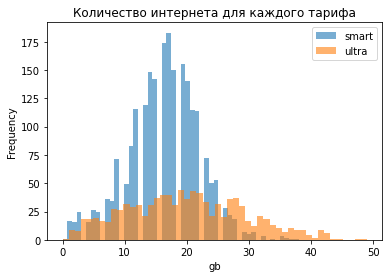

In [32]:
data.groupby('tariff_name')['gb_used'].plot(kind = 'hist', bins = 50, title = 'Количество интернета для каждого тарифа', alpha = 0.6, legend = True)
plt.xlabel('gb')
stats_for_internet = data.pivot_table(index = 'tariff_name', values = 'gb_used', aggfunc = ['mean', 'var', 'std'])
stats_for_internet.columns = ['mean', 'var', 'std']
print(stats_for_internet)

<b>Вывод:</b> оба распределения похожи на нормальные, но с разной дисперсией. По графику видно, что дисперсия и трафика ultra будет больше.

# Проверка гипотез

<b>1 гипотеза<b>: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

H0: выручка тарифа "Ультра" равна выручке тарифа "Смарт".
Значит альтернативная гипотеза H1: выручки не будут равны.

Дисперсия для тарифа smart равна: 669730.7638948115
Дисперсия для тарифа ultra равна: 141387.71480935952
p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


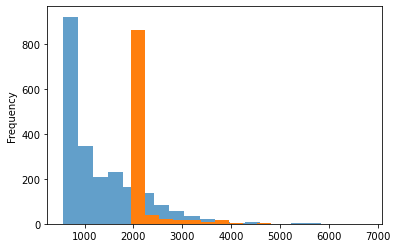

In [33]:
alpha = 0.05

smart = data.query('tariff_name == "smart"')['profit']
ultra = data.query('tariff_name == "ultra"')['profit']

print('Дисперсия для тарифа smart равна:', smart.var())
print('Дисперсия для тарифа ultra равна:', ultra.var())
#Дисперсии выборок отличаются

smart.plot(kind = 'hist', alpha = 0.7, bins = 20)
ultra.plot(kind = 'hist')
#На графиках можно заметить, что распределение нельзя отнести к нормальному.

results = st.ttest_ind(smart, ultra, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Из этого следует, что мы отвергаем нулевую гипотезу. То есть принимаем альтернативную. По всей видимости выручки действительно различаются.

<b>2 гипотеза<b>: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H0: выручка в Москве и других городах одинаковая.
H1: выручка в Москве и других годах различается, не важно в какую сторону.

Дисперсия для дохода в Москве равна: 565636.4670118879
Дисперсия для дохода в других городах равна: 654069.574962777
p-значение: 0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


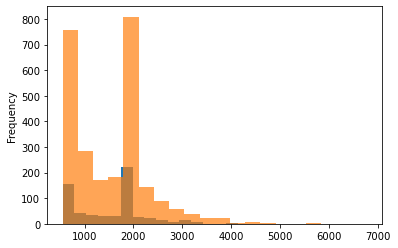

In [34]:
Moscow = data.query('city == "Москва"')['profit']
not_Moscow = data.query('city != "Москва"')['profit']

print('Дисперсия для дохода в Москве равна:', Moscow.var())
print('Дисперсия для дохода в других городах равна:', not_Moscow.var())
#Дисперсия здесь также отличается

Moscow.plot(kind = 'hist', bins = 20)
not_Moscow.plot(kind = 'hist', alpha = 0.7, bins = 20)
#Здесь также нельзя отнести распределение к нормальному

alpha = 0.05

results = st.ttest_ind(Moscow, not_Moscow, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу. То есть скорее всего выручка в Москве и других городах действительно одинаковая.

<b>Вывод:</b> в данном случае применялся метод scipy.stats.ttest_ind (array1, array2, equal_var), так как имеется 2 генеральные совокупности. equal_var передавался как False, так как не считаем дисперсии генеральных совокупностей равными. Уровень значимости был выбран в 5%, так как он считается наиболее надежным и наиболее часто используется и подходит для нашей задачи.

# Общий вывод

Исходные данные были подготовлены, то есть приведены к нужному типу данных. Были определены количество и продолжительность звонков каждого пользователя в месяц, количество сообщений в месяц, а также использование интернета в месяц. В дальнейшем эти данные использовались для подсчета выручки с каждого пользователя за месяц. Также были проверены 2 гипотезы. Первая о равенстве средней выручки с каждого пользователя тарифов «Ультра» и «Смарт». Эта гипотеза не подтвердилась. Вероятно выручки от двух тарифов все-таки разные. И вторая гипотеза равенстве средней выручки от пользователей из Москвы и из других городов. Данную гипотезу уже не получилось отвергнуть. Из это можно сделать вывод, что есть вероятность, что выручки будут равны.